In [1]:
import pandas as pd
import numpy as np
import cv2
from easydict import EasyDict
import yaml

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn import CrossEntropyLoss, NLLLoss # 损失函数定义

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Data

在当前文件夹下查看

In [2]:
# 查看当前文件夹下的文件
%ls

 驱动器 D 中的卷是 软件
 卷的序列号是 20BD-F941

 D:\Jupyter Notebook\DeepLearning 的目录

2023/11/15  23:37    <DIR>          .
2023/11/09  10:12    <DIR>          ..
2023/08/25  09:39             3,238 .gitignore
2023/11/08  17:21    <DIR>          .ipynb_checkpoints
2023/08/09  09:33         3,746,322 2_CNN架构的视觉骨架网络.ipynb
2023/11/15  22:43            36,343 2022年计算机视觉SOTA实践.ipynb
2023/08/09  09:33         2,581,419 3_Transformer架构的视觉骨架网络.ipynb
2023/08/09  09:33            40,317 3_数据增强练习.ipynb
2023/11/15  23:37            45,070 beasline学习 （第二次）.ipynb
2023/11/09  10:13    <DIR>          Data
2023/11/10  10:11    <DIR>          test
               6 个文件      6,452,709 字节
               5 个目录 215,865,229,312 可用字节


In [3]:
%ls .\Data

 驱动器 D 中的卷是 软件
 卷的序列号是 20BD-F941

 D:\Jupyter Notebook\DeepLearning\Data 的目录

2023/11/09  10:13    <DIR>          .
2023/11/15  23:37    <DIR>          ..
2023/11/09  10:13    <DIR>          digit-recognizer
               0 个文件              0 字节
               3 个目录 215,865,229,312 可用字节


In [4]:
%ls .\Data\digit-recognizer

 驱动器 D 中的卷是 软件
 卷的序列号是 20BD-F941

 D:\Jupyter Notebook\DeepLearning\Data\digit-recognizer 的目录

2023/11/09  10:13    <DIR>          .
2023/11/09  10:13    <DIR>          ..
2023/11/08  17:27           240,909 sample_submission.csv
2023/11/08  17:27        51,118,296 test.csv
2023/11/08  17:27        76,775,041 train.csv
               3 个文件    128,134,246 字节
               2 个目录 215,865,229,312 可用字节


数据读取

In [5]:
train = pd.read_csv("./Data/digit-recognizer/train.csv")
test = pd.read_csv("./Data/digit-recognizer/test.csv")
submission = pd.read_csv("./Data/digit-recognizer/sample_submission.csv")

查看数据

In [6]:
train.head(2) # 图片直接存在pixel中 28*28=784

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


查看图片

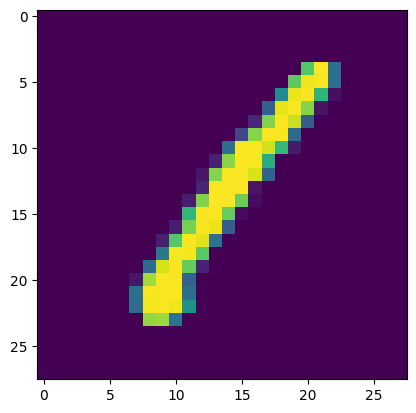

In [7]:
plt.imshow(train.iloc[0,1:].values.reshape(28,28)) # 取第0行的第一列（pixel0开始）往后的数，reshape成28*28打印

查看shape

In [8]:
train.shape

(42000, 785)

In [9]:
test.head(2)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


submission 提交格式 

imageid就是test中的序号，其实就是把test集中的数据预测出来放入submission的label中

In [10]:
submission.head(2) 

,ImageId,Label
0,1,0
1,2,0


### 数据类型转换


- csv读入的数据是DataFrame类型
- 把csv中pixel部分数据取出来的数据转换成numpy类型

In [11]:
train_images = train.iloc[:,1:].values.reshape(-1,28,28)
train_labels = train.iloc[:,0].values
test_images = test.iloc[:,0:].values.reshape(-1,28,28)

In [12]:
train_images.shape

(42000, 28, 28)

In [13]:
test_images.shape

(28000, 28, 28)

In [14]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

查看训练集的数据分布，均值

In [15]:
train_images.std()/255

0.3085401559245608

In [16]:
train_images.mean()/255

0.13101533792088266

In [17]:
train_images.max()

255

## Image Augmentation

1. 图片增强
2. 图片尺寸 Resize
3. 标准化 Normalize
4. 匹配到模型的input format

In [18]:
def get_transform(image_size,train=True):
    # 训练阶段使用
    if train: 
        return A.Compose([
#                     A.RandomCrop(width=22, height=22), # 随即裁剪 可能是版本和opencv的版本冲突
                    A.HorizontalFlip(p=0.5), # 水平翻转
                    A.VerticalFlip(p=0.5),   # 垂直翻转
                    A.RandomBrightnessContrast(p=0.2), 
                    A.Resize(*image_size,interpolation=cv2.INTER_LANCZOS4), # 形状统一必不可少
                    A.Normalize(0.1310,0.3085), # 标准化，
                    ToTensorV2()  # 把数据转化为Pytorch格式
                ])
    # 测试阶段使用
    else:
         return A.Compose([
                    A.Resize(*image_size,interpolation=cv2.INTER_LANCZOS4), # 取决于测试集的图片大小，如果和训练集一样大，可以不要
                    A.Normalize(0.1310,0.3085), # 标准化
                    ToTensorV2()  # 把数据转化为Pytorch格式
                ])
        

In [19]:
# train_transform = get_transform((28,28),True) # 这里是初始化一个图像变换算符

In [20]:
#train_transform(image = train_images[0]) # 传入train_images[0] 这个变量

In [21]:
# output = train_transform(image = train_images[0]) # 返回的是变换后的train_images[0]

数据增强后的数据

In [22]:
# output['image'].std()

In [23]:
# output['image'].mean()

In [24]:
# plt.imshow(output['image'].squeeze().numpy()) # 使用squeeze把数据维度中不存在的实际通道删去

# Dataset

In [25]:
class MiniDataSet(Dataset):
    
    # 传入数据
    def __init__(self,images,labels=None,transform=None):
        self.images = images.astype("float32") # 转化为floate方便后面计算
        self.labels = labels
        self.transform = transform
         
    # 获取长度
    def __len__(self):
        return len(self.images)
    
    # 提取列表数据
    def __getitem__(self,idx):
        ret = {}  # 返回是一个字典，包含变换后的图像数据与标签数据
        img = self.images[idx]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        ret["image"] = img
        
        # 假如输入是有label的
        if self.labels is not None:
            ret["label"] = self.labels[idx]
        return ret

In [26]:
# ds = MiniDataSet(train_images,train_labels,get_transform((28,28),True)) # ds=字典

In [27]:
# 对于ds这个字典来说
# ds[idx]返回一个字典对象
# ds[idx]["image"]或者ds[idx]["label"]通过键访问该对象中的值

#ds[0]["image"] # 取字典中的量

# Model

In [28]:
class MiniModel(nn.Module):
    def __init__(self,backbone,num_class,pretrained=False,backbone_ckpt=None):
        
        # 写作规范
        super().__init__() 
        self.backbone = timm.create_model(backbone,pretrained=pretrained,checkpoint_path=backbone_ckpt,in_chans=1)
        # 模型做预训练默认三通道，我们的数据集只有单通道，所以需要加上通道数in_chans

        # 定义自己的分类头
        self.head = nn.Linear(self.backbone.get_classifier().in_features,num_class)# nn.Linear的输入维度可以看convnext_small原网络这层的输入
        # 定义自己的分类层
        self.backbone.head.fc = nn.Identity()
        self.loss_fn = NLLLoss()
        
    
    def forward(self,image,label=None):
        embed = self.backbone(image) # 编码
        logit = self.head(embed) # 分类
        
        if label is not None:
            logit_logsoftmax = torch.log_softmax(logit,1)  #  预测  
            loss = self.loss_fn( logit_logsoftmax,label)  # 损失函数
            return {"prediction":logit,"loss":loss}
        
        return {"prediction" :logit}
    

- 因为28对于convnext_samll模型来说尺寸太小，所以在这里做图片尺寸缩放，在get_transform中变换

In [29]:
# ds = MiniDataSet(train_images,train_labels,get_transform((224,224),True))

In [30]:
# model = MiniModel("convnext_small",10,True)

In [31]:
# train_images.dtype

In [32]:
# ds.images = ds.images.astype("float32")

In [33]:
# ds[0]['image'].shape

In [34]:
# ds[0]['image'].unsqueeze(0).shape

In [35]:
# model(ds[0]['image'].unsqueeze(0))

查看网络的属性

In [36]:
# net = timm.create_model("convnext_small")

In [37]:
# net

In [38]:
# net.head

查看线性层的输入

In [39]:
# net.get_classifier().in_features 

In [40]:
# net.head.fc = nn.Identity()  # 把net.head.fc层取出，令它等于一个恒等层

In [41]:
# net.head

## Pipeline 

- train_fn
- eval_fn
- pred_fn


In [42]:
# model.train() # 模型转化为训练阶段

In [43]:
def train_one_epoch(model,optimizer,dataloader,device):
    model.to(device) # 选择设备
    model.train() # 开始训练模式
    train_loss = []
    
    for batch in tqdm(dataloader):
        output = model(batch["image"].to(device),batch["label"].to(device))
        optimizer.zero_grad() # 清零梯度
        output["loss"].backward() # 计算梯度
        optimizer.step() # 优化器更新
        train_loss.append(output['loss'].item()) # item方法可以避免显卡被卡死
 
    return np.mean(train_loss)  # 返回训练过程中的一个平均loss

def eval_one_epoch(model,dataloader,device):
    model.to(device) # 选择设备
    model.eval() # 开始训练模式
    eval_loss = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device),batch["label"].to(device))
        eval_loss.append(output['loss'].item()) # item方法可以避免显卡被卡死
 
    return np.mean(eval_loss)  # 返回训练过程中的一个平均loss

def predict(model,dataloader,device):
    model.to(device) # 选择设备
    model.eval() # 开始训练模式
    predictions = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device))
        prediction = torch.argmax(output['prediction'],1)
        predictions.append(prediction.cpu()).numpy() # 保存数据
        
    predictions = np.concatenate(predictions,axis=0)
    return predictions


## Experiment

In [44]:
CONFIG = EasyDict({
    "backbone":"convnext_small",
    "num_class": 10,
    "image_size":(32,32),
    "pretrained":True,
    "epochs":5,
    "batch_size":256,
    "num_workers":0,
    "device":"cpu"
})

In [45]:
CONFIG.backbone

'convnext_small'

数据集定义

In [46]:
train_transform = get_transform(CONFIG.image_size, True)
valid_transform = get_transform(CONFIG.image_size, False)


full_train_ds = MiniDataSet(train_images, train_labels, train_transform)
train_ds = MiniDataSet(train_images[:40000], train_labels[:40000], train_transform)
val_ds = MiniDataSet(train_images[40000:], train_labels[40000:], valid_transform)
test_ds = MiniDataSet(test_images, transform=valid_transform)

In [47]:
# len(full_train_ds)

dataloader定义

In [48]:
full_train_dl = DataLoader(full_train_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=True, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=False, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=False, drop_last=False)

model定义

In [49]:
model = MiniModel(backbone=CONFIG.backbone, num_class=CONFIG.num_class, pretrained=CONFIG.pretrained)
optimizer = Adam(model.parameters(), lr=0.0005)

In [50]:
model.parameters() # 包含网络的weight, bias,等

<generator object Module.parameters at 0x00000154C8259200>

### 训练过程

In [51]:
for epoch in range(CONFIG.epochs):
    train_loss = train_one_epoch(model, optimizer, train_dl, CONFIG.device)
    val_loss = eval_one_epoch(model, val_dl, CONFIG.device)
    print(f"Epoch_{epoch+1}, train loss {train_loss:.4f}, val loss {val_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [41:12<00:00, 15.85s/it]


Epoch_1, train loss 1.6984, val loss 0.3675


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [27:31<00:00, 10.59s/it]


Epoch_2, train loss 0.6126, val loss 0.1959


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [27:31<00:00, 10.59s/it]


Epoch_3, train loss 0.5733, val loss 0.0875


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [27:31<00:00, 10.59s/it]


Epoch_4, train loss 0.5371, val loss 0.1070


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [27:23<00:00, 10.54s/it]


Epoch_5, train loss 0.5347, val loss 0.0833


In [ ]:
val_prediction = predict(model, val_dl, device=CONFIG.device)
test_prediction = predict(model, test_dl, device=CONFIG.device)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(train_labels[40000:], val_prediction)

In [ ]:
submission["Label"] = test_prediction
submission.to_csv("./submit.csv", index=False)